In [23]:
from collections import Counter
from sklearn.model_selection import train_test_split
import random
from openai import OpenAI
import json
import os
from sklearn.metrics import precision_recall_curve, roc_curve, auc, accuracy_score
import time

In [38]:
seed_value=117629
random.seed(seed_value)
def read_mtop_file(file_path):
    data = []
    with open(file_path, 'r', encoding='utf-8') as file:
        for line in file:
            fields = line.strip().split('\t')
            if len(fields) < 8:
                continue  # Skip any malformed lines
            record = {
                'ID': fields[0],
                'Intent': fields[1],
                'Utterance': fields[3],
                'Domain': fields[4]
            }
            data.append(record)
    return data

def select_ood_domains(domains, num_ood):
    return ["timer"]  # Hardcoded OOD domains

# Configuration parameters
english_dir = 'mtop/en'

# Read dataset
all_data = read_mtop_file(f'{english_dir}/test.txt') + \
           read_mtop_file(f'{english_dir}/train.txt') + \
           read_mtop_file(f'{english_dir}/eval.txt')

domains = set(record['Domain'] for record in all_data)
ood_domains = select_ood_domains(domains, 1)  # Using 1 as hardcoded number of OOD domains

# Separate OOD data based on domain
in_domain_data = [record for record in all_data if record['Domain'] not in ood_domains]
ood_data = [record for record in all_data if record['Domain'] in ood_domains]

intent_counts = Counter(record['Intent'] for record in in_domain_data)

# Filter intents with at least 10 instances
sufficient_data = [record for record in in_domain_data if intent_counts[record['Intent']] > 10]

train_val_data, test_data = train_test_split(
    sufficient_data, test_size=0.2, random_state=seed_value, stratify=[record['Intent'] for record in sufficient_data]
)
train_data, val_data = train_test_split(
    train_val_data, test_size=0.125, random_state=seed_value, stratify=[record['Intent'] for record in train_val_data]
)

# Split OOD data between validation and test
oos_val_data, oos_test_data = train_test_split(ood_data, test_size=0.67, random_state=seed_value)  # No stratification here since it's all OOD

# Extract sentences and labels
train_sentences = [record['Utterance'] for record in train_data]
 # Chop off first 3 characters from each intent
train_labels = [record['Intent'][3:] for record in train_data]

val_sentences = [record['Utterance'] for record in val_data]
val_labels = [record['Intent'][3:] for record in val_data]

test_sentences = [record['Utterance'] for record in test_data]
test_labels = [record['Intent'][3:] for record in test_data]

oos_val_sentences = [record['Utterance'] for record in oos_val_data]
oos_test_sentences = [record['Utterance'] for record in oos_test_data]

# Summary of splits
summary = {
    "OOD Domains": ood_domains,
    "Train Set Size": len(train_sentences),
    "Validation Set Size": len(val_sentences),
    "Test Set Size": len(test_sentences),
    "OOS Validation Set Size": len(oos_val_sentences),
    "OOS Test Set Size": len(oos_test_sentences)
}


model_name = "ce_model_bert_mtop.pth"
summary

{'OOD Domains': ['timer'],
 'Train Set Size': 14465,
 'Validation Set Size': 2067,
 'Test Set Size': 4134,
 'OOS Validation Set Size': 491,
 'OOS Test Set Size': 997}

In [39]:
system_prompt = '''
You are an AI assistant specialized in natural language processing tasks. You will be provided with training samples consisting of sentences and their corresponding intents. Your task is to determine whether a given sentence is in-scope (belongs to a known intent) or out-of-scope (does not belong to any known intent).
Based on the provided training data, classify each input sentence and return a JSON object indicating whether the sentence is in-scope or out-of-scope. If the sentence is in-scope, also provide the intent name. If the sentence is out-of-scope, indicate that it is out-of-scope. The in-scope intents must match exactly with the intents provided in the training data except for oos.
Instructions: 1. For each input sentence, determine if it is in-scope or out-of-scope based on the provided training data. 2. If the sentence is in-scope, return a JSON object with { inscope: true, scope: "intent_name" }. The intent name must match exactly with the intents provided in the training data. 3. If the sentence is out-of-scope, return a JSON object with { inscope: false, scope: "oos" }.
'''

In [40]:
# Initialize the OpenAI client
client = OpenAI()

# Control variable for the number of training samples
num_training_samples = 200

# Combine sentences and labels into training data
training_data = list(zip(train_sentences, train_labels))

unique_intents = list(set(train_labels))
sampled_training_data = [random.choice([data for data in training_data if data[1] == intent]) for intent in unique_intents]

# Sample additional training data if needed
additional_samples_needed = max(0, num_training_samples - len(sampled_training_data))
if additional_samples_needed > 0:
    additional_samples = random.sample(training_data, additional_samples_needed)
    sampled_training_data.extend(additional_samples)

training_data_string = "Training Data:\n"
training_data_string += "\n".join([f"{sentence} - {intent}" for sentence, intent in sampled_training_data])

user_content_template = f"{training_data_string}\n\nInput Sentence:\n{{}}"
# # Function to query OpenAI API
# def query_openai(input_sentence, sampled_sentences, sampled_intents):
#     # Create the user content with sampled training data
#     user_content = f"{training_data_string}\n\nInput Sentence:\n{input_sentence}"

#     # Query OpenAI API
#     response = client.chat.completions.create(
#         model="gpt-4o",
#         response_format={ "type": "json_object" },
#         messages=[
#             {"role": "system", "content": system_prompt},
#             {"role": "user", "content": user_content}
#         ]
#     )
#     response_content = response.choices[0].message.content
#     response_json = json.loads(response_content)

#     # Return the boolean and intent
#     inscope = response_json["inscope"]
#     scope = response_json["scope"]
#     return inscope, scope


In [41]:
# Combine test sentences and oos test sentences
all_sentences = test_sentences + oos_test_sentences
all_labels = test_labels + ["oos"] * len(oos_test_sentences)
# Create JSONL entries

jsonl_entries = []
for index, sentence in enumerate(all_sentences):
    user_content = user_content_template.format(sentence)
    entry = {
        "custom_id": f"{index}",
        "method": "POST",
        "url": "/v1/chat/completions",
        "body": {
            "model": "gpt-3.5-turbo",
            "response_format": { "type": "json_object" },
            "messages": [
                {"role": "system", "content": system_prompt},
                {"role": "user", "content": user_content}
            ],
            "max_tokens": 256
        }
    }
    jsonl_entries.append(entry)



In [42]:
len(all_sentences)

5131

In [43]:
# entries_per_file = 50
# num_files = (len(jsonl_entries) + entries_per_file - 1) // entries_per_file

# for i in range(num_files):
#     start_index = i * entries_per_file
#     end_index = min((i + 1) * entries_per_file, len(jsonl_entries))
#     output_file = f'gpt3.5-t200-request-part{i+1}.jsonl'
#     with open(output_file, 'w') as f:
#         for entry in jsonl_entries[start_index:end_index]:
#             f.write(json.dumps(entry) + '\n')
#     print(f"JSONL file '{output_file}' created successfully.")

## upload file via file api

In [44]:
# batch_input_id = []
# for i in range(1, num_files + 1):
#         filename = f'gpt3.5-t200-request-part{i}.jsonl'
#         response = client.files.create(file=open(filename, "rb"), purpose="batch")
#         file_id = response.id
#         # Append the file ID to the list
#         batch_input_id.append(file_id)

## create batch and check every minute

In [45]:
# output_file_ids = []
# i = 1
# # Iterate over each input file ID and process the batch
# for file_id in batch_input_id:
#     # Create the batch
#     batch_run = client.batches.create(
#         input_file_id=file_id,
#         endpoint="/v1/chat/completions",
#         completion_window="24h"
#     )
    
#     # Extract the batch ID
#     batch_id = batch_run.id
#     print(f"Created batch with ID: {batch_id}")
    
#     # Query the status of the batch until it is completed
#     while True:
#         batch_status = client.batches.retrieve(batch_id)
#         status = batch_status.status
#         print(f"Batch {i} status: {status}")
        
#         if status == "completed":
#             # Save the output file ID
#             output_file_id = batch_status.output_file_id
#             print(f"Batch {batch_id} completed. Output file ID: {output_file_id}")
#             output_file_ids.append(output_file_id)
#             i += 1
#             break
#         elif status == "failed":
#             print(f"Batch {batch_id} failed.")
#             break
        
#         # Wait for 1 minute before querying again
#         time.sleep(60)

In [46]:
filepath = f"gpt-response/gpt3-t200-response-{seed_value}.jsonl"
# with open(filepath, 'wb') as combined_output_file:
#     for out_id in output_file_ids:
#         content_response = client.files.content(out_id)
#         content = content_response.read()
#         combined_output_file.write(content)

In [47]:
# import zipfile


# with zipfile.ZipFile('gpt4o-t1000-requests.zip', 'w', zipfile.ZIP_DEFLATED) as zipf:
#     for i in range(1, num_files + 1):
#         filename = f'gpt4o-t1000-request-part{i}.jsonl'
#         zipf.write(filename)

# print("All parts have been zipped and compressed into 'gpt4o-t1000-requests.zip'")


# Analysis of Result

In [48]:
responses = []
with open(filepath, 'r') as file:
    for line in file:
        responses.append(json.loads(line))

In [49]:
y_true = []
y_pred = []
predicted_intents = []
for response in responses:
    custom_id = int(response['custom_id'])
    label = all_labels[custom_id]
    y_true.append(1 if label == 'oos' else 0)

    response_content = json.loads(response['response']['body']['choices'][0]['message']['content'])
    inscope = response_content['inscope']
    predicted_intent = response_content['scope'] if inscope else 'oos'
    predicted_intents.append(predicted_intent)
    y_pred.append(0 if inscope else 1) 

In [50]:
precision, recall, _ = precision_recall_curve(y_true, y_pred)
fpr, tpr, _ = roc_curve(y_true, y_pred)

aupr = auc(recall, precision)
auroc = auc(fpr, tpr)


In [51]:
print(f'AUPR: {aupr}')
print(f'AUROC: {auroc}')

AUPR: 0.6211814486458204
AUROC: 0.6377038711684156


In [52]:
aupr = average_precision_score(y_true, y_scores)

NameError: name 'average_precision_score' is not defined

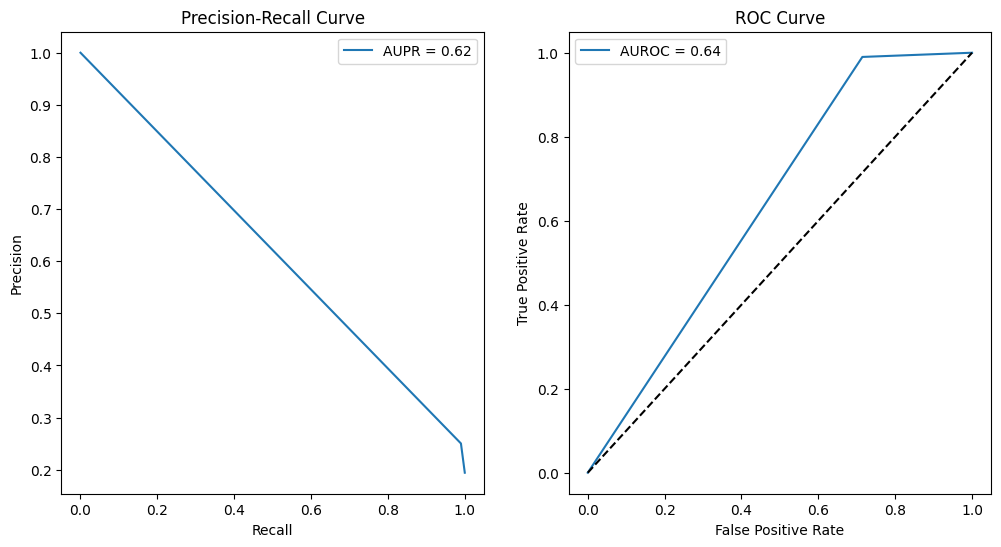

In [53]:
import matplotlib.pyplot as plt

# Plot Precision-Recall curve
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(recall, precision, label='AUPR = %0.2f' % aupr)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()

# Plot ROC curve
plt.subplot(1, 2, 2)
plt.plot(fpr, tpr, label='AUROC = %0.2f' % auroc)
plt.plot([0, 1], [0, 1], 'k--')  # Dashed diagonal
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()

plt.show()


In [ ]:
system_prompt = '''
You are an AI assistant specialized in natural language processing tasks. You will be provided with training samples consisting of sentences and their corresponding intents. Your task is to classify a given sentence's intent.
Based on the provided training data, classify the input sentence and return a JSON object indicating the intent of the sentence. The intents must match exactly with the intents provided in the training data.
return a JSON object with { intent: "intent_name" }.
'''

In [ ]:
# Combine test sentences and oos test sentences
all_sentences = test_sentences
all_labels = test_labels
# Create JSONL entries

jsonl_entries = []
for index, sentence in enumerate(all_sentences):
    user_content = user_content_template.format(sentence)
    entry = {
        "custom_id": f"{index}",
        "method": "POST",
        "url": "/v1/chat/completions",
        "body": {
            "model": "gpt-3.5-turbo",
            "response_format": { "type": "json_object" },
            "messages": [
                {"role": "system", "content": system_prompt},
                {"role": "user", "content": user_content}
            ],
            "max_tokens": 256
        }
    }
    jsonl_entries.append(entry)
    
entries_per_file = 50
num_files = (len(jsonl_entries) + entries_per_file - 1) // entries_per_file

for i in range(num_files):
    start_index = i * entries_per_file
    end_index = min((i + 1) * entries_per_file, len(jsonl_entries))
    output_file = f'gpt3.5-t200-classification-request-part{i+1}.jsonl'
    with open(output_file, 'w') as f:
        for entry in jsonl_entries[start_index:end_index]:
            f.write(json.dumps(entry) + '\n')
    print(f"JSONL file '{output_file}' created successfully.")

In [ ]:
batch_input_id = []
for i in range(1, num_files + 1):
        filename = f'gpt3.5-t200-classification-request-part{i}.jsonl'
        response = client.files.create(file=open(filename, "rb"), purpose="batch")
        file_id = response.id
        # Append the file ID to the list
        batch_input_id.append(file_id)

In [ ]:
len(batch_input_id)

In [ ]:
i = 0
output_file_ids = []
# Iterate over each input file ID and process the batch
for file_id in batch_input_id:
    # Create the batch
    batch_run = client.batches.create(
        input_file_id=file_id,
        endpoint="/v1/chat/completions",
        completion_window="24h"
    )
    
    # Extract the batch ID
    batch_id = batch_run.id
    print(f"Created batch with ID: {batch_id}")
    
    # Query the status of the batch until it is completed
    while True:
        batch_status = client.batches.retrieve(batch_id)
        status = batch_status.status
        print(f"Batch {i} status: {status}")
        
        if status == "completed":
            # Save the output file ID
            output_file_id = batch_status.output_file_id
            print(f"Batch {batch_id} completed. Output file ID: {output_file_id}")
            output_file_ids.append(output_file_id)
            i += 1
            break
        elif status == "failed":
            print(f"Batch {batch_id} failed.")
            break
        
        # Wait for 1 minute before querying again
        time.sleep(60)

In [ ]:
filepath = f"gpt-response/gpt3-t200-classfication-{seed_value}.jsonl"
with open(filepath, 'wb') as combined_output_file:
    for out_id in output_file_ids:
        content_response = client.files.content(out_id)
        content = content_response.read()
        combined_output_file.write(content)

In [ ]:
responses = []
with open(filepath, 'r') as file:
    for line in file:
        responses.append(json.loads(line))

In [ ]:
true_in_scope_labels = []
predicted_in_scope_labels = []
for response in responses:
    custom_id = int(response['custom_id'])
    true_in_scope_labels.append(all_labels[custom_id])
    response_content = json.loads(response['response']['body']['choices'][0]['message']['content'])
    try:
        predicted_intent = response_content['intent']
        predicted_in_scope_labels.append(predicted_intent)
    except:
        print(response_content)


In [ ]:
accuracy = accuracy_score(true_in_scope_labels, predicted_in_scope_labels)

In [ ]:
print(f'Classification Accuracy (In-Scope): {accuracy}')